## 1. Preparación del ambiente

In [ ]:
# Instalación de paquetes en la VM de Colab
!python -m pip install wordcloud
!python -m nltk.downloader all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_t

In [ ]:
# Librerías Python
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

import seaborn as sns
import json
import requests
import gzip




## 2. Pre procesamiento de datos

### 2.1 Carga del dataset

In [ ]:
#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2022-08-08 02:11:40--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz.1’

Software_5.json.gz. 100%[===================>]   5.09M  20.3MB/s    in 0.3s    

2022-08-08 02:11:40 (20.3 MB/s) - ‘Software_5.json.gz.1’ saved [5339013/5339013]



In [ ]:
# Creación del Data Frame a partir del Data Set. Ya que el data set es grande, se elige la categoría "Musical Instruments" para optimizar el ejercicio.
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Software_5.json.gz')

In [ ]:
# Se verifica el contenido
df.sample(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
329,5.0,False,"09 7, 2009",AHX935LEAJB0,B000050ZRE,{'Color:': ' 0.9810945108'},RGA,"I bought it two month ago, my modem and router...",IT works flawless,1252281600,NaN,NaN
11546,5.0,True,"03 25, 2016",AD85M8MCAFJKY,B015724RQI,{'Platform:': ' 10D PC/Mac Download'},Linda Joy,Reliable software I continue to buy,Trusted and Reliable,1458864000,NaN,NaN
4719,4.0,False,"07 30, 2010",A3NOBH42C7UI5M,B003JZN5QO,NaN,Kepela,If you need the special features this program ...,"WinZip 14, what would we do without WinZip",1280448000,NaN,NaN
4975,4.0,True,"03 30, 2014",A1GNYKVAT4ZHT1,B003YJ5DKG,{'Platform:': ' PC Disc'},Buzz Stephens,I've been using Quicken since the MS-DOS versi...,Just Replaced Version 2006 with 2011 - and It ...,1396137600,NaN,NaN
6182,5.0,True,"12 26, 2012",A2THQCHKR89E16,B005S4Y13K,{'Format:': ' Software Download'},D. Bryan,"Don't waste you time, energy, and especially m...",Saves you money,1356480000,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12805 entries, 0 to 12804
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         12805 non-null  float64
 1   verified        12805 non-null  bool   
 2   reviewTime      12805 non-null  object 
 3   reviewerID      12805 non-null  object 
 4   asin            12805 non-null  object 
 5   style           7161 non-null   object 
 6   reviewerName    12796 non-null  object 
 7   reviewText      12804 non-null  object 
 8   summary         12799 non-null  object 
 9   unixReviewTime  12805 non-null  int64  
 10  vote            3902 non-null   object 
 11  image           71 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 1.2+ MB


Reduzco los datos a trabajar

In [ ]:
# Dejo sólo las columnas necesarias
df = df[['reviewText','overall']]
# Elimino valores nan
df = df.dropna()

exploratory_data_analysis
Number of reviews: 12804


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


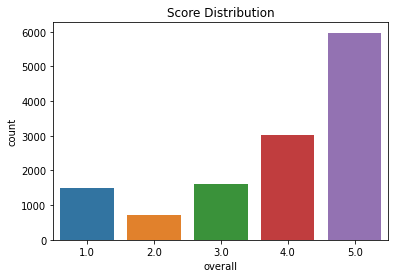

In [ ]:
print("exploratory_data_analysis")
print("Number of reviews:", len(df))
# Score Distribution
ax = plt.axes()
sns.countplot(df.overall, ax=ax)
ax.set_title('Score Distribution')
plt.show()

Se descarta el valor neutral 3.0 y se agrega la columna con valores binarios positive/negative

In [ ]:
# Se descarta el valor neutral 3.0
df = df[df.overall != 3.0]

In [ ]:
# Se define una nueva columna con valores positive (rating 4 o 5) y negative (rating 1 o 2)
def sentiment(n):return "positive" if n >= 4.0 else "negative"
df['sentiment'] = df['overall'].apply(sentiment)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


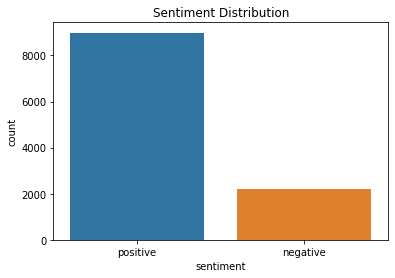

In [ ]:
ax = plt.axes()
sns.countplot(df.sentiment, ax=ax)
ax.set_title('Sentiment Distribution')
plt.show()

In [ ]:
# Reduzco los datos y elimino overall
#df = df[['reviewText','sentiment']]

In [ ]:
# Se separan los datos para test y train
from sklearn.model_selection import train_test_split
train, test = train_test_split(df,test_size = 0.3)

## 3. Visualizando los datos

In [ ]:
train_pos = train[ train['sentiment'] == 'positive']
train_pos = train_pos['reviewText']
train_neg = train[ train['sentiment'] == 'negative']
train_neg = train_neg['reviewText']


test_pos = test[ test['sentiment'] == 'positive']
test_pos = test_pos['reviewText']
test_neg = test[ test['sentiment'] == 'negative']
test_neg = test_neg['reviewText']

In [ ]:
# The Image shape in which you wanna convert it to.
from PIL import Image
!wget 'https://guiaimpresion.com/wp-content/uploads/2020/06/Logotipo-Amazon.jpg'
mask = np.array(Image.open(r'Logotipo-Amazon.jpg'))

--2022-08-08 02:11:43--  https://guiaimpresion.com/wp-content/uploads/2020/06/Logotipo-Amazon.jpg
Resolving guiaimpresion.com (guiaimpresion.com)... 217.79.247.226
Connecting to guiaimpresion.com (guiaimpresion.com)|217.79.247.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25523 (25K) [image/jpeg]
Saving to: ‘Logotipo-Amazon.jpg.1’

Logotipo-Amazon.jpg 100%[===================>]  24.92K  --.-KB/s    in 0.07s   

2022-08-08 02:11:43 (338 KB/s) - ‘Logotipo-Amazon.jpg.1’ saved [25523/25523]



Palabras positivas


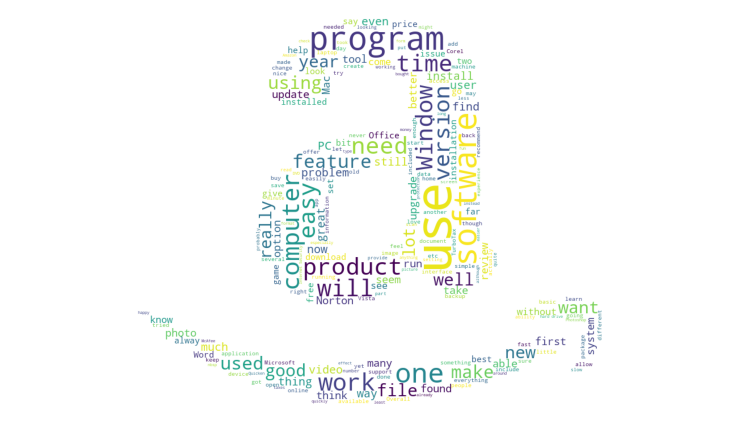

Palabras negativas


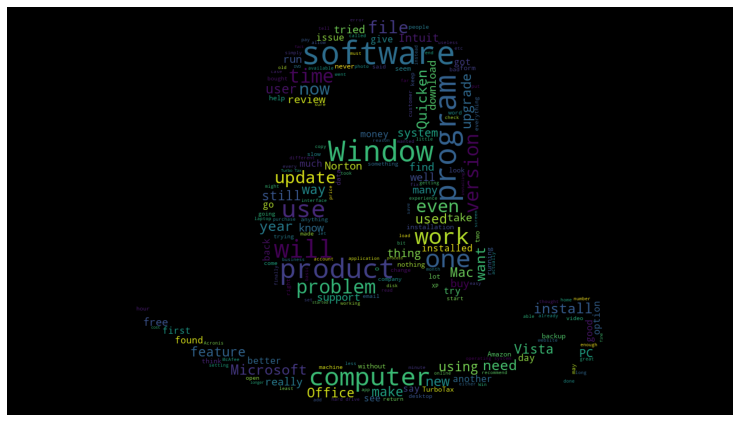

In [ ]:
def wordcloud_draw(df, color = 'black'):
    words = ' '.join(df)
    ''' Limpio el texto eliminando hashtags, menciones, links y retweets.
    '''
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      mask = mask,
                      background_color=color,
                      #width=2500,
                      #height=2000
                      width = mask.shape[1],
                      height = mask.shape[0]
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Palabras positivas")
wordcloud_draw(train_pos,'white')
print("Palabras negativas")
wordcloud_draw(train_neg)

## 4. Limpieza, normalization, stop-words

In [ ]:
def clean(dataset):
    tweets = []
    #Tomo una lista de stopwords
    stopwords_set = set(stopwords.words("english"))
    #Itero sobre los datos de entrenamiento
    for index, row in dataset.iterrows():
        '''
        Iterar sobre los datos y:
        -Quedarse únicamente con palabras de largo mayor a 2 caracteres
        -Transformar todas las palabras a minúscula
        -Eliminar palabras que comiencen con @,#
        -Eliminar stopwords

        Guardar en el vector tweets un vector por cada tweet donde:
        -el primer elemento sea un array con todas las palabras luego de la limpieza
        -el segundo elemento sea el sentimiento asociado 
        '''
        #Filtro palabras muy cortas y transformo a minúscula
        words_filtered = [e.lower() for e in row.reviewText.split() if len(e) >= 3]
        #Filtro hashtags, etc.
        words_cleaned = [word for word in words_filtered
            if 'http' not in word
            and not word.startswith('@')
            and not word.startswith('#')
            and word != 'RT']
        #Elimino stopwords
        words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
        #Guardo en vector tweets con el label correspondiente (positivo o negativo)
        tweets.append((words_without_stopwords,row.sentiment))
    return tweets
    
reviews = clean(train)
test_reviews = clean(test)

In [ ]:
reviews[3000]

(['well,',
  'bought',
  'year',
  'taxes.',
  'using',
  'turbo',
  'tax',
  'previous',
  'yrs.',
  'tried',
  'import',
  'previous',
  'years',
  'tax',
  'info,',
  'started',
  'asking',
  'files',
  'such.',
  'know',
  'files?',
  'so,',
  'stopped',
  'using',
  'it.'],
 'negative')

## 5. Metodo: Clasificador Naive Bayes

In [ ]:
# Se listan todas las palabras en un único vector para contar la frecuencia de aparición
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

all_words = get_words_in_tweets(reviews)

In [ ]:
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(all_words)

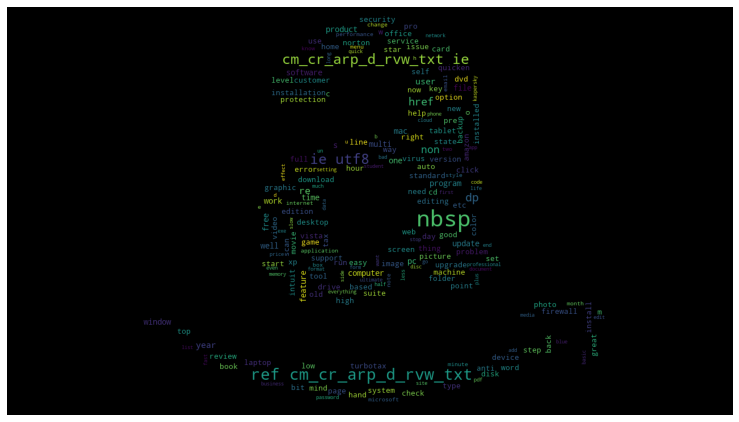

In [ ]:
wordcloud_draw(w_features)

In [ ]:
def extract_features(document):
    ''' Se utiliza el set de un documento en vez de búsqueda en una lista por temas de eficiencia.'''
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contiene(%s)' % word] = (word in document_words)
    return features

In [ ]:
# Entrenamiento (puede demorar)
training_set = nltk.classify.apply_features(extract_features,reviews)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [ ]:
classifier.show_most_informative_features(5)

Most Informative Features
         contiene(junk.) = True           negati : positi =     36.8 : 1.0
       contiene(claimed) = True           negati : positi =     30.3 : 1.0
        contiene(worse,) = True           negati : positi =     29.5 : 1.0
       contiene(intuit,) = True           negati : positi =     28.6 : 1.0
    contiene(nightmare.) = True           negati : positi =     27.0 : 1.0


In [ ]:
# Accuracy
print(nltk.classify.accuracy(classifier, training_set[0:500]))

0.912


In [ ]:
test_set = nltk.classify.apply_features(extract_features,test_reviews)
print(nltk.classify.accuracy(classifier, test_set[0:500]))

0.866
